<a href="https://colab.research.google.com/github/rges-pit/minicourses/blob/main/chapter4/Day_4_homework_fit_PSPL_event.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font face="Helvetica" size="7">Chapter 4: Fitting a single-lens event</font>  

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

<i> Authors: Katarzyna Kruszyńska, Amber Malpas, Somayeh Khakpash, Ali Crisp </i>

<br>

If you would like an introduction to python notebooks, please read this tutorial: https://medium.com/codingthesmartway-com-blog/getting-started-with-jupyter-notebook-for-python-4e7082bd5d46

Please note, you must **save this notebook in a space owned by you** (a GitHub repo, gist, to Google Drive, or locally) if you want to come back to it later without losing your progress. You can edit and run this notebook on Colab, but it **will not auto save** for you.

### <font face="Helvetica" size="5"> Running locally and local runtimes </font>

*Ignore this section if you already did these steps for another notebook.*

If you choose to use lcoal resources your notebook will use your local packages, so you should install a virtual environment with the following packages. Run the cell below to create a downloadable `.yml` file, to automate the package install process (provided you are using anaconda). Failing that, you can download it from the [git repository](https://github.com/rges-pit/minicourses.git).

In [ ]:
# @title `.yml`
yaml = '''name: minicourse
channels:
  - conda-forge
dependencies:
  - python=3.11
  - numpy
  - matplotlib
  - pandas
  - scipy
  - jupyter
  - ipython
  - astropy
  - beautifulsoup4
  - lxml              # required parser for bs4
  - pip
  - pip:
      - pathos
      - MulensModel
      - pyLIMA'''

# save the yaml
with open('environment.yml', 'w') as f:
    f.write(yaml)

Click the folder button on the side bar to open the file explorer. The file `environment.yml` should be in there now. Just click the triple dots on the side and then `Download` to download the `.yml` file.

```bash
conda env create -f environment.yml
```

Running the above line in a terminal (Anaconda Prompt on Windows) will create a virtual conda environment called `minicourse`, which has the required packages installed.

You can activate the environment with:

```bash
conda activate minicourse
```

From here you have two options

1. You can open the notebook running
```bash
jupyter notebook
```
from a parent folder to your locally saved version of this notebook and navigating to the notebook in your browser. You may need to select `minicourse` as your kernel before running the notebook.

2. Alternatly, you can create a local "Runtime" and for your Colab notebook by following [these instructions](https://www.google.com/url?q=https%3A%2F%2Fresearch.google.com%2Fcolaboratory%2Flocal-runtimes.html).
```bash
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --no-browser
```

  ⚠️ We don't generally recommend that you do this with notebooks that you didn't write as it give them access to your local machine

<!-- -->

### <font face="Helvetica" size="5"> Clone the rges-pit/minicourses repo </font>

Do this weather you are running locally or on the cloud, if you do not already have the repo cloned. It has necessary data.

In [ ]:
#@title Clone the rges-pit/minicourses repo
!git clone https://github.com/rges-pit/minicourses

Cloning into 'minicourses'...
remote: Enumerating objects: 522, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 522 (delta 72), reused 76 (delta 65), pack-reused 427 (from 1)
Receiving objects: 100% (522/522), 82.11 MiB | 12.45 MiB/s, done.
Resolving deltas: 100% (188/188), done.
Updating files: 100% (173/173), done.


In [ ]:
!ls -a ./minicourses/
%cd minicourses/
!git status

.   chapter1  chapter3	chapter5  .gitignore  README.md
..  chapter2  chapter4	.git	  LICENSE     trials
/content/minicourses
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [ ]:
!git pull
!git status

Already up to date.
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


## <font face="Helvetica" size="6"> 1. Introduction </font>

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

Welcome to **Chapter 4: Homework - Fitting a single-lens event.**

This notebook contains a homework exercise for you to complete in you own time, but preferably before tomorrow's wprkshop. This exercise was adapted from the [**SingleLens**](https://github.com/AmberLee2427/TheMicrolensersGuideToTheGalaxy/blob/main/Notebooks/SingleLens.ipynb) notebook by Amber Malpas. We highly recommend checking out `The Microlensiers Guide to the Galaxy` if you're looking for more information on microlensing. We also followed [**`MulensModel` Example 2**](https://github.com/rpoleski/MulensModel/blob/master/examples/example_02_fitting.py).

In this exercise, you will fit a single, point-source-point-lens (PSPL) microlensing event. Such an event has a single peak, but it may be assymetrical (or even have wobbles) due to the **parallax** effect or have a flatter peak due to the **finite source** effect.

Here, we will focus on fitting the event with the [**MulensModel**](https://github.com/rpoleski/MulensModel) package developed by Radek Poleski, Jennifer Yee and collaborators. There are many other packages you can use in the future:
- [**`pyLIMA`**](https://github.com/ebachelet/pyLIMA),
- [**`BAGLE`**](https://github.com/MovingUniverseLab/BAGLE_Microlensing),
- [**`VBMicrolensing`**](https://github.com/valboz/VBMicrolensing),
- [**`RTModel`**](https://github.com/valboz/RTModel),
- ...,
  
but here we will focus on `MulensModel` to introduce you to the general idea of how these packages work.

### <font face="Helvetica" size="5"> 1.1 Load packages </font>


In [ ]:
import os

from typing import Tuple, Callable, Optional, List

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import minimize

# microlensing tool
!pip install MulensModel
import MulensModel as mm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.1/634.1 kB 7.7 MB/s eta 0:00:00


In [ ]:
#@title Removing the 'data' file inside `mulensmodel_dir`

mulensmodel_dir = os.path.dirname(mm.__file__)
data_file_path = os.path.join(mulensmodel_dir, 'data')

if os.path.exists(data_file_path):
  if os.path.isfile(data_file_path):
    os.remove(data_file_path)
  else:
    shutil.rmtree(data_file_path)
  print(f"Removed 'data' file or directory from {mulensmodel_dir}")
else:
  print(f"No 'data' file or directory found in {mulensmodel_dir}")

Removed 'data' file or directory from /usr/local/lib/python3.11/dist-packages/MulensModel


In [ ]:
#@title Replace this path with the path printed above, if they are different
!ls /usr/local/lib/python3.11/dist-packages/MulensModel

### <font face="Helvetica" size="5"> 1.2 Necessary functions </font>

In [ ]:
def flux2mag(flux: np.ndarray,
             zp: Optional[float] = 25.0
             ) -> np.ndarray:
    '''
    Converts flux values (array) to magnitude.

    Parameters
    ----------
    mag : np.ndarray
        Array of magnitudes.
    zp : float, optional
        Zero point of the magnitude system (default is 25.0).

    Returns
    -------
    f : np.ndarray
        Array of magnitudes.
    '''
    f = zp - (2.5 * np.log10(flux))
    return f


def mag2flux(mag: np.ndarray,
             zp: Optional[float] = 25.0
             ) -> np.ndarray:
    '''
    Converts magnitude values (array) to flux.

    Parameters
    ----------
    mag : np.ndarray
        Array of magnitudes.
    zp : float, optional
        Zero point of the magnitude system (default is 25.0).

    Returns
    -------
    f : np.ndarray
        Array of fluxes.
    '''
    f = 10.0**((mag - zp) / -2.5)
    return f

def mag2flux_err(mag: np.ndarray, mag_err: np.ndarray,
                 zp: Optional[float] = 25.0):
    '''
    Converts magnitude values and errors (array) to flux using error propagation formula.

    Parameters
    ----------
    mag : np.ndarray
        Array of magnitudes.
    mag_err : np.ndarray
        Array of magnitude errors.
    zp : float, optional
        Zero point of the magnitude system (default is 25.0).

    Returns
    -------
    flux_err : np.ndarray
        Array of flux errors.
    '''
    dfdmag = -0.4 * np.log(10) * 10.**(0.4*(zp-mag))
    flux_err = np.sqrt(dfdmag**2 * mag_err**2)
    return flux_err

def read_data(data_dir: str,
              extension: Optional[List[str]] = ['dat','diapl','pysis','txt']
              ) -> dict:
    '''
    Reads in the data from a directory.

    Parameters
    ----------
    dir : str
        Directory path.

    Returns
    -------
    data : dict
        Dictionary containing the data.
        Keys are observatory names, and values are tuples of (t_data, flux_data, flux_err_data).
            t_data : np.ndarray
                Time data.
            mag_data : np.ndarray
                Magnitude data.
            mag_err_data : np.ndarray
                Magnitude error data.
    '''
    data = {} # initalizing data dictinary

    # list of all the 'dat' files in data_directory
    files = [f for f in os.listdir(data_dir) if f.split('.')[-1] in extension]

    print(files)

    files.sort() # alphabetise the data files

    for f in files:

        if 'horizon' in f:
            continue

        # creating the path to each data file
        if data_dir[-1] == '/':
            datafile = data_dir + f
        else:
            datafile = data_dir + '/' + f

        # Reading in the data
        t_data = np.loadtxt(datafile, usecols=0)
        mag = np.loadtxt(datafile, usecols=1)
        mag_err = np.loadtxt(datafile, usecols=2)

        if 'OGLE' in f:  # (HJD, mag, mag_err, quality?, sky counts?)
            observatory = 'OGLE'
            flux_data = mag2flux(mag, zp=28.)
            flux_err_data = mag2flux_err(mag, mag_err, zp=28)
        if 'Spitzer' in f:  # (HJD, mag, mag_err)
            observatory = 'Spitzer'
            flux_data = mag2flux(mag, zp=28.)
            flux_err_data = mag2flux_err(mag, mag_err, zp=28)
        if 'KMT' in f:
            t_data = t_data + 2450000.
            flux_data = mag2flux(mag, zp=28.)
            flux_err_data = mag2flux_err(mag, mag_err, zp=28.65)

            if 'KMTA' in f:  # (HJD, mag, mag_err)
                observatory = 'KMT-A'
            elif 'KMTC' in f:
                observatory = 'KMT-C'
            elif 'KMTS' in f:
                observatory = 'KMT-S'

        data[observatory] = (t_data, flux_data, flux_err_data)

    return data

## <font face="Helvetica" size="6"> 2. Data </font>

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">


In [ ]:
#@title Data directories

# if this line doesn't work, double check your file path matches what you see
# in the finder (the folder icon on the sidebar in `colab`)
data_dir = os.path.abspath('chapter4/data/events/OB170002/')

data = read_data(data_dir)

['KMTS42_I.txt', 'KMTA42_I.txt', 'KMTC42_I.txt', 'OGLE-2017-BLG-0002.txt']


Now we will add the data with the `MulensData` class ([**see documentation**](https://rpoleski.github.io/MulensModel/MulensModel.mulensdata.html#module-MulensModel.mulensdata)). This class not only remembers what sort of data we have for each light curve but can also hold information on the units of the data we have, used filters and plotting parameters. It also has some useful methods that can help with working with the data.

In [ ]:
#@title Creating `MulensModel`, `MulensData` objects
OB170002_KMTC_data = mm.MulensData(data_list = data['KMT-C'],
                                            plot_properties={'color':'purple', 'label':'KMT-C', 'marker':'x', 'markersize':2},
                                            phot_fmt='flux',
                                            bandpass='I')
OB170002_KMTA_data = mm.MulensData(data_list = data['KMT-A'],
                                            plot_properties={'color':'violet', 'label':'KMT-A', 'marker':'x', 'markersize':2},
                                            phot_fmt='flux',
                                            bandpass='I')
OB170002_KMTS_data = mm.MulensData(data_list = data['KMT-S'],
                                            plot_properties={'color':'plum', 'label':'KMT-S', 'marker':'x', 'markersize':2},
                                            phot_fmt='flux',
                                            bandpass='I')
OB170002_OGLE_data = mm.MulensData(data_list = data['OGLE'],
                                            plot_properties={'color':'thistle', 'label':'OGLE', 'marker':'x', 'markersize':2},
                                            phot_fmt='flux',
                                            bandpass='I')

OB170002_data = [OB170002_KMTC_data, OB170002_KMTA_data, OB170002_KMTS_data, OB170002_OGLE_data]

### <font face="Helvetica" size="5"> 2.1 Plotting the data </font>
Now let's take a look at this data!

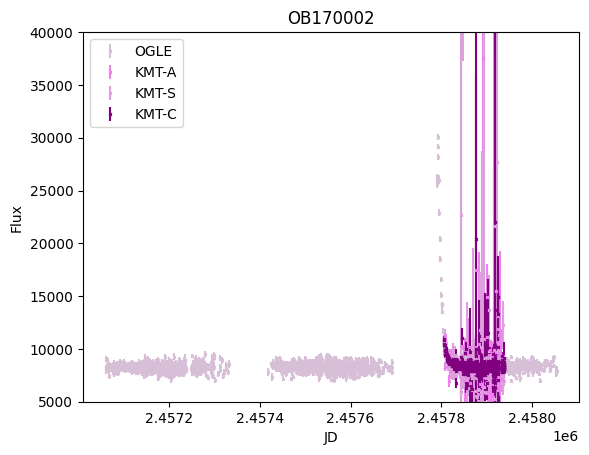

In [ ]:
#@title Example plot

plt.figure()
# MulensModel has a very handy method for MulensData class
OB170002_OGLE_data.plot()
OB170002_KMTA_data.plot()
OB170002_KMTS_data.plot()
OB170002_KMTC_data.plot()

plt.legend()
plt.ylim(5000, 40000)
plt.title('OB170002')
plt.ylabel('Flux')
plt.xlabel('JD')

# Use this line to change the plot window
# plt.xlim(2457000., 2458000.)
# plt.ylim(5000., 35000.)

plt.show()

What a pretty event! You can zoom in to check its features using the zoom button in jupyter notebook and jupyter lab, or by editing the `xlim` and `ylim` plot attributes in the cell above.

## <font face="Helvetica" size="6"> 3. PSPL model </font>

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

#### <font face="Helvetica" size="5"> 3.1 Define the PSPL model (using `MulensModel`, `Model` objects) </font>

Let's define a single event model for this using `MulensModel` `Model` class ([**see documentation**](https://rpoleski.github.io/MulensModel/MulensModel.model.html#module-MulensModel.model)). This model will not have any extra features (for now).

In [ ]:
#@title Initial guess

t0, u0, tE = 2457792., 0.3, 10 # you can guess the parameters here
Theta0 = np.array([t0, u0, tE])  # initial guess
labels = np.array(['t_0', 'u_0', 't_E']) # parameter labels

# We define the MulensModel model object here
OB170002_pspl = mm.Model({'t_0': t0, 'u_0': u0, 't_E': tE})

Let's check how well our guess fits to the data.

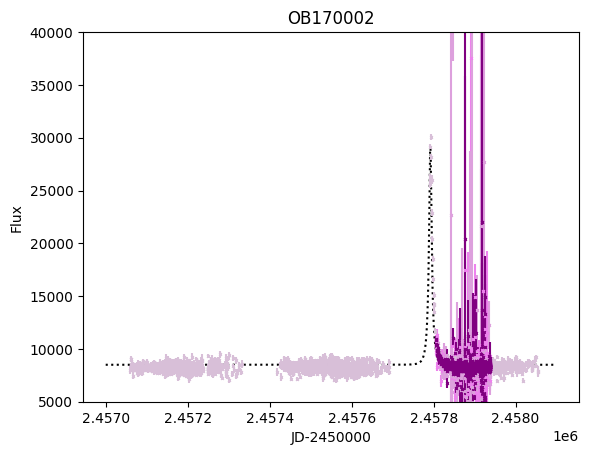

In [ ]:
plt.figure()

t = np.linspace(2457000, 2458100, 2000)  # time range
A0 = OB170002_pspl.get_magnification(t)  # initial guess magnification curve
plt.plot(t, A0*8500, label='Initial Guess', color='black', linestyle=':')

OB170002_OGLE_data.plot()
OB170002_KMTA_data.plot()
OB170002_KMTS_data.plot()
OB170002_KMTC_data.plot()

plt.title('OB170002')
plt.ylabel('Flux')
plt.xlabel('JD-2450000')

plt.ylim(5000, 40000)
# plt.xlim(2457000., 2458000.)

plt.show()

Nice! Let's try fitting a PSPL model to this event using MulensModel.

#### <font face="Helvetica" size="5"> 3.2 Making a `MulensModel`, `Event` object </font>

First we have to define a `MulensModel` `Event` object ([**see documentation**](https://rpoleski.github.io/MulensModel/MulensModel.event.html#module-MulensModel.event)). It will rememeber all important information about the event for us.

In [ ]:
OB170002 = mm.Event(datasets=OB170002_data, model=OB170002_pspl)

Now, we have to define a function that will measure how well our current model fits to data. In microlensing, we often use $\chi^2$ for this. This means we will be minimizing the $\chi^2$ value to find the best-fitting parameters.

#### <font face="Helvetica" size="5"> 3.3 Setting up the fit </font>

In [ ]:
#@title Defining our objective function

def chi2_fun(theta, parameters_to_fit, event):
    """
    Calculate chi2 for given values of parameters.

    Parameters
    ----------
    theta : np.ndarray
        Vector of parameter values, e.g., `np.array([5380., 0.5, 20.])`.
    parameters_to_fit : list of str
        List of names of parameters corresponding to theta, e.g., `['t_0', 'u_0', 't_E']`.
    event : MulensModel.Event
        Event which has datasets for which chi2 will be calculated.

    Returns
    -------
    chi2 : float
        Chi2 value for given model parameters.

    Notes
    -----
    Function from MulensModel documentation:
    https://github.com/rpoleski/MulensModel/blob/master/examples/example_02_fitting.py
    """
    # First we have to change the values of parameters in
    # event.model.parameters to values given by theta.
    for (parameter, value) in zip(parameters_to_fit, theta):
        setattr(event.model.parameters, parameter, value)

    # After that, calculating chi2 is trivial:
    return event.get_chi2()

Let's see how well the initial guess fits to the data.

In [ ]:
#@title Testing the initial guess

print('Initial Parameter Guess:\n{0}'.format(OB170002.model.parameters))
print('chi^2 = %.2f'%(chi2_fun(Theta0, labels, OB170002)))

Initial Parameter Guess:
    t_0 (HJD)       u_0    t_E (d) 
2457792.00000  0.300000    10.0000 
chi^2 = 28887.42


### <font face="Helvetica" size="5"> 3.4 Finding the best-fitting PSPL solution </font>

Let's see if we can find a better fitting solution (a set of model parameters that is more likely to have produce the observed data). We will use `minimize` function from `scipy.optimize` package ([**see documentation here**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)).

In [ ]:
#@title Find the best-fit parameters

# Theta0 is our vector with starting parameters.
# We also have to pass parameter names (labels) and event object (OB170002)
# to let the fitting function on what event we will be working on
result = minimize(
    chi2_fun, x0=Theta0, args=(labels, OB170002),
    method='Nelder-Mead')

Theta_fit = result.x

print('Final Parameters:\n{0}'.format(OB170002.model.parameters))
print('chi^2 = %.2f'%(chi2_fun(Theta_fit, labels, OB170002)))

print('\nDifference in chi^2 between initial guess and fitted parameters')
print('delta_chi^2 = %.2f'%(chi2_fun(Theta0, labels, OB170002) - chi2_fun(Theta_fit, labels, OB170002)))

Final Parameters:
    t_0 (HJD)       u_0    t_E (d) 
2457792.81524  0.251112    13.9763 
chi^2 = 27518.26

Difference in chi^2 between initial guess and fitted parameters
delta_chi^2 = 1369.16


### <font face="Helvetica" size="5"> 3.5 Displaying the results </font>
Great! Let's display our initial and final solutions together!

/usr/local/lib/python3.11/dist-packages/MulensModel/utils.py:147: UserWarning: Flux to magnitude conversion approached negative flux
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/MulensModel/utils.py:150: RuntimeWarning: invalid value encountered in log10
  mag = zeropoint - 2.5 * np.log10(flux)
/usr/local/lib/python3.11/dist-packages/MulensModel/mulensdata.py:504: UserWarning: Some good data points have scaled errorbars with negative values. Setting them to zero for plotting.
Dataset: KMT-A
Epochs: [2457910.31023]
  warnings.warn(msg.format(kind, self._get_name(), self.time[indexes]))


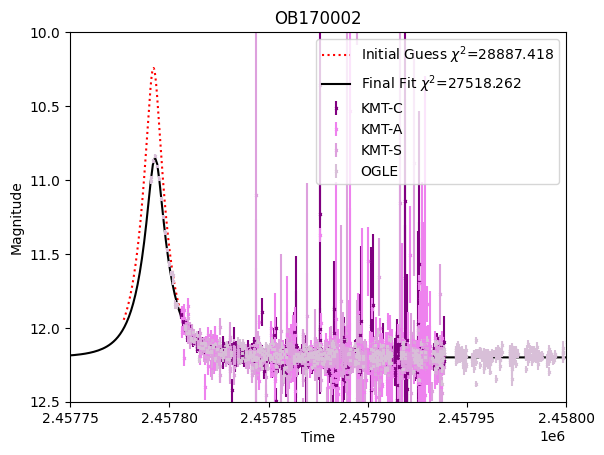

In [ ]:
#@title Final plot

plt.figure()

chi20 = chi2_fun(Theta0, labels, OB170002)  # initial guess chi2

init_model = mm.Model({'t_0': t0, 'u_0': u0, 't_E': tE})
init_fit = mm.FitData(dataset=OB170002_data[0], model=init_model)
init_fit.fit_fluxes()

init_model.plot_lc(source_flux=init_fit.source_flux,
                   blend_flux=init_fit.blend_flux,
                   label='Initial Guess $\chi^2$=%1.3f'%chi20,
                   color='#a859e4',
                   linestyle=':'
                   )

chi2_fit = chi2_fun(Theta_fit, labels, OB170002)  # fitted parameters chi2
OB170002.plot_model(label='Final Fit $\chi^2$=%1.3f'%chi2_fit,
                    color='#361d49',
                    linestyle='-',
                    t_range=[2457000, 2458100]
                    )

# MulensModel automatically fits for the source and blend flux for the
# given model.
OB170002.plot_data()

plt.legend(loc='best')
plt.title('OB170002')
plt.ylim(12.5, 10)
plt.xlim(2457750,2458000)
plt.show()

## <font face="Helvetica" size="6"> 4. Adding the finite source effect </font>

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

Okay! Now, we will complicate our model a bit. Let's add the finite source effect, which occurs when the source size is comparable to the size of the Einstein ring.

We will follow the same procedure as before. There will be some areas left for you to fill, following the examples above.

### <font face="Helvetica" size="5"> 4.1 Define FSPL `Model` object </font>

In [ ]:
#@title Initial guess

t0, u0, tE, rho = 2457792, 0.3, 10, 0.01 # some values we guessed.
Theta0FSPL = np.array([t0, u0, tE, rho])  # initial guess
labelsFSPL = np.array(['t_0', 'u_0', 't_E', 'rho']) # parameter labels

OB170002_fspl = mm.Model({'t_0': t0, 'u_0': u0, 't_E': tE, 'rho': rho})

# Here, we specify that we impose the finite source effect on our event
# We do that by setting the magnification method
OB170002_fspl.set_magnification_methods([2450000., 'finite_source_uniform_Gould94', 2470000.]) # rho <= 0.1

Let's plot the initial guess.

In [ ]:
#@title Initial plot
plt.figure()
t = np.linspace(2457000, 2458100, 2000)  # time range
A0 = OB170002_fspl.get_magnification(t)  # initial guess magnification curve
plt.plot(t, A0*8500, label='Initial Guess', color='black', linestyle=':')

#######
# You can also plot the data here.

#######

plt.show()

ValueError: File with FSPL data does not exist.
/usr/local/lib/python3.11/dist-packages/MulensModel/data/interpolation_table_b0b1_v3.dat

<Figure size 640x480 with 0 Axes>

In [ ]:
# Define the mulens model with the FSPL model like in the example shown before
OB170002 = []

print('Initial Parameter Guess:\n{0}'.format(OB170002.model.parameters))
print('chi^2 = %.2f'%(chi2_fun(Theta0FSPL, labelsFSPL, OB170002)))

### <font face="Helvetica" size="5"> 4.2 Finding the best-fitting FSPL solution </font>
We are leaving this part up to you. Just follow the same procedure as Section 3.1, but with the new `Model` object.

In [ ]:
# Now find the best-fitting model similarly like above

### <font face="Helvetica" size="5"> 4.3 Display the results </font>

In [ ]:
#@title Final plot

# Plot your results! We already put the initial guess model
plt.figure()

chi20 = chi2_fun(Theta0FSPL, labelsFSPL, OB170002)  # initial guess chi2

init_model = mm.Model({'t_0': t0, 'u_0': u0, 't_E': tE})
init_fit = mm.FitData(dataset=OB170002_data[0], model=init_model)
init_fit.fit_fluxes()

init_model.plot_lc(
    source_flux=init_fit.source_flux, blend_flux=init_fit.blend_flux,
    label='Initial Guess $\chi^2$=%1.3f'%chi20, color='#a859e4', linestyle=':')

### If you're feeling adventurous, you can also try plotting the best-fitting FSPL solution

#### Put the code for plotting the best-fitting FSPL solution



## <font face="Helvetica" size="6"> 5. Adding parallax effect </font>

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

We will now show you how to add the parallax effect to your event. For this, however, we will need a different event. For the previous event, the parallax effect would be hard to catch because it was short, and all observatories were located on Earth. If we were lucky and had a highly magnified event observed densely, we might catch terrestial parallax like in the case of [**OGLE-2007-BLG-224 event**](https://ui.adsabs.harvard.edu/abs/2009ApJ...698L.147G/abstract).

The parallax effect can (and should) be included, however, in the case of longer events or events which were observed by both Earth- and space-based observatories.

For this exercise, we will use event OGLE-2014-BLG-0939, which was published in [**Yee et al. 2015**](https://ui.adsabs.harvard.edu/abs/2015ApJ...802...76Y/abstract). Both OGLE and *Spitzer Space Telescope* observed this event. We adapted [**Example 12 for `MulensModel`**](https://github.com/rpoleski/MulensModel/blob/master/examples/example_12_fit_satellite_parallax_EMCEE.py).

### <font face="Helvetica" size="5"> 5.1 Load the data </font>

In [ ]:
# Data directory
data_dir = os.path.abspath('chapter4/data/events/OB140939/')

data = read_data(data_dir)

We add OGLE data like in the examples before.

In [ ]:
OB140939_OGLE_data  = mm.MulensData(data_list = data['OGLE'],
                                            plot_properties={'color':'thistle', 'label':'OGLE', 'marker':'x', 'markersize':2},
                                            phot_fmt='flux',
                                            bandpass='I')

### <font face="Helvetica" size="5"> 5.2 Emphemerides </font>

For Spitzer, we have to account for the observatory being located in space. This will also be relevant for any Roman events you might work on in the future.

To make this work, you have to know the position of the satellite in the Solar system. You can do that by getting its ephemeris from [**the JPL Horizons system**](https://ssd.jpl.nasa.gov/horizons/). You may be familiar with this system from classes about Solar System Objects. JPL Horizons provides ephemerides not only for astronomical objects in the Solar System but also for a myriad of satellites sent by humans (202 according to [**this website**](https://ssd.jpl.nasa.gov/horizons/manual.html)), which we checked on April 9th 2025).

For this exercise, we pre-downloaded the Spitzer ephemeris, but we encourage you to do this by yourself, following this [**wonderful tutorial by Radek Poleski**](https://github.com/rpoleski/MulensModel/blob/master/documents/Horizons_manual.md).

In [ ]:
ephem_path = os.path.abspath('./data/events/OB140939/spitzer_horizons_results.ephem')

OB140939_spitzer_data = mm.MulensData(data_list = data['Spitzer'], ephemerides_file=ephem_path,
    plot_properties={'color':'firebrick', 'label':'Spitzer', 'marker':'o', 'markersize':2},
                                            phot_fmt='flux')

OB140939_data = [OB140939_OGLE_data, OB140939_spitzer_data]

Let's have a look at the data.

In [ ]:
plt.figure()
# MulensModel has a very handy method for MulensData class
OB140939_OGLE_data.plot()
OB140939_spitzer_data.plot()

plt.legend()
plt.title('OB140939')
plt.ylabel('Flux')
plt.xlabel('JD-2450000')
plt.show()

### <font face="Helvetica" size="5"> 5.3 Define PSPL `Model` with parallax effect </font>

When modelling events with parallax effect, it is important to know the coordinates of the event.

You also have to specify the parameter reference time $t_{0,par}$.
Following [**Skowron et al. 2011, Appendix A**](https://ui.adsabs.harvard.edu/abs/2011ApJ...738...87S/abstract): The parameters of an event with parallax are customarily measured in a geocentric frame ([**An et al. 2002**](https://ui.adsabs.harvard.edu/abs/2002ApJ...572..521A/abstract), [**Gould 2004**](https://ui.adsabs.harvard.edu/abs/2004ApJ...614..404G/abstract)). In this frame, "all parameters are measured in the instantaneous frame that is at rest with respect to the Earth at a specifically adopted time", $t_{0,par}$. This parameter is **not** be fitted.

The choice of $t_{0,par}$ is not random. In general, it is a good practice to set it at the time of peak, or at time of the planetary anomaly.

In [ ]:
#@title Extra set-up and inital guess

coords = '17:47:12.25 -21:22:58.7' # coordinates passed in hh:mm:ss and dd:mm:ss format

# You can guess the parameters here
t0, u0, tE = 2456837., 0.5, 30 # you can guess the parameters here
piEN, piEE = 0., 0. # let's assume for now that the parallax vector has length 0.
t0par = 2456837. # we set t_{0,par} at the peak

# We will define the starting parameters a bit differently
# Starting parameters:
start_params = {
    't_0': t0, 'u_0': u0, 't_E': tE,
    'pi_E_N': piEN, 'pi_E_E': piEE,
    't_0_par': t0par}
Theta0_par = [t0, u0, tE, piEN, piEE]
# Which parameters we want to fit?
labels_to_fit = ["t_0", "u_0", "t_E", "pi_E_N", "pi_E_E"]

OB140939_pspl_par = mm.Model(start_params, coords=coords)

Let's see how this looks.

In [ ]:
#@title Initial plot

plt.figure()

t = np.linspace(2456000, 2457000, 2000)  # time range
A0 = OB140939_pspl_par.get_magnification(t)  # initial guess magnification curve
plt.plot(t, A0*110000, label='Initial Guess', color='black', linestyle=':')

OB140939_OGLE_data.plot()
OB140939_spitzer_data.plot()

plt.legend()
plt.title('OB140939')
plt.ylabel('Flux')
plt.xlabel('JD-2450000')
plt.show()

### <font face="Helvetica" size="5"> 5.4 Finding the best-fitting PSPL solution with parallax effect >

In [ ]:
#@title Define the `MulensModel` `Event`
OB140939 = mm.Event(datasets=OB140939_data, model=OB140939_pspl_par)

print('Initial Parameter Guess:\n{0}'.format(OB140939.model.parameters))
print('chi^2 = %.2f'%(chi2_fun(Theta0_par, labels_to_fit, OB140939)))

In [ ]:
#@title Fitting

# Find the best-fit parameters
# We'll do this exactly the same way as in previous examples,
# so you know how to do it!


### <font face="Helvetica" size="5"> 5.5 Display the results </font>

In [ ]:
#@title Final plot

# Plot your results! We already put the initial guess model
plt.figure()

chi20 = chi2_fun(Theta0_par, labels, OB140939)  # initial guess chi2

init_model = mm.Model(start_params, coords=coords)
init_fit = mm.FitData(dataset=OB140939_data[0], model=init_model)
init_fit.fit_fluxes()

init_model.plot_lc(
    source_flux=init_fit.source_flux, blend_flux=init_fit.blend_flux,
    label='Initial Guess\n$\chi^2$=%.2f'%chi20, color='#a859e4', linestyle=':')

### If you're feeling adventurous, you can also try plotting the best-fitting PSPL solution
### Without parallax effect


#### Put the code for plotting the best-fitting PSPL solution with parallax

